# minGPT

**Note:** The `autoreload` extension allows the interpreter to reload modules every time a cell is executed. This is useful when editing the code in a module. The following cell enables the extension and downloads the minGPT package from Github. You can now double-click on a file like model.py, edit its contents, and press Ctrl+S to save it. If you then re-run the notebook cells, including those that create an object of the corresponding class, you will see the changes reflected. Note that the next cell should *only be executed once*, as running `pip install` again will overwrite the modified contents of the module.

Recall that changes in the files (except the notebook itself) are not persistent unless you connect them to your Google Drive account.

In [ ]:
%load_ext autoreload
%autoreload 2
%pip install -e 'git+https://github.com/karpathy/minGPT.git@37baab71b9abea1b76ab957409a1cc2fbfba8a26#egg=mingpt'

# Fix this issue: https://github.com/karpathy/minGPT/issues/120
!sed -i '200s/.*/        assert len(keys) == len([k for k in sd if not k.endswith(".attn.bias")])/' /content/src/mingpt/mingpt/model.py


Obtaining mingpt from git+https://github.com/karpathy/minGPT.git@37baab71b9abea1b76ab957409a1cc2fbfba8a26#egg=mingpt
  Skipping because already up-to-date.
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mingpt
    Found existing installation: minGPT 0.0.1
    Uninstalling minGPT-0.0.1:
      Successfully uninstalled minGPT-0.0.1
  Running setup.py develop for mingpt


Add module's location to PYTHONPATH, which tells your Python interpreter where to search modules for. The previous `pip install -e` changes the variable in a subshell and the interpreter is therefore not aware of the updated value.

In [ ]:
import sys
sys.path.append('/content/src/mingpt')

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
set_seed(3407)

In [ ]:
use_mingpt = True # use minGPT or huggingface/transformers model?
model_type = 'gpt2'
device = 'cpu'

In [ ]:
if use_mingpt:
    model = GPT.from_pretrained(model_type)
else:
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.config.pad_token_id = model.config.eos_token_id # suppress a warning

# ship model to device and set to eval mode
model.to(device)
model.eval();

number of parameters: 124.44M


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

def generate(prompt='', num_samples=10, steps=20, do_sample=True):

    # tokenize the input prompt into integer input sequence
    if use_mingpt:
        tokenizer = BPETokenizer()
        if prompt == '':
            # to create unconditional samples...
            # manually create a tensor with only the special <|endoftext|> token
            # similar to what openai's code does here https://github.com/openai/gpt-2/blob/master/src/generate_unconditional_samples.py
            x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
        else:
            x = tokenizer(prompt).to(device)
    else:
        tokenizer = GPT2Tokenizer.from_pretrained(model_type)
        if prompt == '':
            # to create unconditional samples...
            # huggingface/transformers tokenizer special cases these strings
            prompt = '<|endoftext|>'
        encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
        x = encoded_input['input_ids']

    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)

    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)


In [ ]:
generate(prompt='Andrej Karpathy, the Earth representative on', num_samples=10, steps=20)

--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on the Council of Europe, said "I would like to ask the President to ensure that the international cooperation
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on the ground in the southern hemisphere, believes that the Earth is in phase with what our solar system has
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on the Soyuz 1 launch window, who was also present during Wednesday's briefing alongside the Russian deputy Russian
--------------------------------------------------------------------------------
Andrej Karpathy, the Earth representative on a satellite that has been orbiting for more than 40 years and is designed to carry back data from other
-----------------------------------------------------------------

In [ ]:
import torch
from mingpt.bpe import BPETokenizer
from mingpt.model import GPT
import matplotlib.pyplot as plt
import numpy as np

# Inicializar el modelo GPT y el tokenizer
model = GPT.from_pretrained('gpt2')  # Asegúrate de cargar el modelo correcto
model.eval()  # Modo evaluación
bpe = BPETokenizer()

# Texto limpio y tokenización
clean_text = "Michelle Jones was a top-notch student. Michelle"
print(f"Clean text: {clean_text}")
tokens_clean = bpe(clean_text)[0]  # Tokeniza el texto
input_length = tokens_clean.size(0)

    # Ejecutar el modelo en el texto limpio
with torch.no_grad():
    logits, _ = model(tokens_clean.unsqueeze(0))  # Guarda activaciones
    last_logits = logits[0, -1, :]  # Logits del último token
    print(f"Logits shape: {last_logits.shape}")

# Mostrar continuaciones más probables
probabilities = torch.softmax(last_logits, dim=-1)
top_k = 20  # Número de continuaciones más probables a mostrar
top_indices = torch.topk(probabilities, k=top_k).indices
top_probabilities = probabilities[top_indices]

print(f"Top {top_k} continuations:")
for i, index in enumerate(top_indices):
    token_str = bpe.decode(torch.tensor([index.item()]))  # Decodificar token
    prob = top_probabilities[i].item()
    print(f"{i + 1}: {token_str} ({prob:.4f})")

# Ejemplo para obtener la probabilidad de un token específico (e.g., "Jones")
token_to_check = " Jones"
index_to_check = bpe(token_to_check)[0][0].item()
prob_of_token = probabilities[index_to_check].item()
print(f"Probability of '{token_to_check.strip()}': {prob_of_token:.4f}")

corrupt_text = "Michelle Smith was a top-notch student. Michelle"

number of parameters: 124.44M
Clean text: Michelle Jones was a top-notch student. Michelle
Logits shape: torch.Size([50257])
Top 20 continuations:
1:  was (0.1634)
2:  Jones (0.1396)
3: 's (0.0806)
4:  had (0.0491)
5:  is (0.0229)
6:  and (0.0227)
7: , (0.0222)
8:  said (0.0134)
9:  has (0.0120)
10:  also (0.0117)
11:  came (0.0091)
12:  told (0.0084)
13:  didn (0.0070)
14:  knew (0.0067)
15:  went (0.0061)
16:  would (0.0061)
17:  worked (0.0055)
18:  did (0.0054)
19:  Obama (0.0053)
20:  wasn (0.0050)
Probability of 'Jones': 0.1396


In [ ]:
def analyze_embeddings(model, tokenizer, clean_text, corrupted_text, target_tokens):
    """
    Analyze the impact of embeddings on logits for a given corrupted text.

    Args:
        model: GPT model.
        tokenizer: BPE tokenizer.
        clean_text (str): Clean sequence.
        corrupted_text (str): Corrupted sequence.
        target_tokens (list): Tokens to analyze logits for (e.g., ["Jones", "Smith"]).

    Returns:
        None
    """
    # Tokenize texts
    clean_tokens = tokenizer(clean_text)[0]
    corrupted_tokens = tokenizer(corrupted_text)[0]
    input_tensor = corrupted_tokens.unsqueeze(0)

    # Process clean sequence
    model.eval()
    with torch.no_grad():
        model.forward(clean_tokens.unsqueeze(0), save_embeddings=True)
        clean_logits = model.stored_logits  # Save logits from the clean sequence
        print(f"Logits shape: {clean_logits.shape}")

    # Mostrar continuaciones más probables
    probabilities = torch.softmax(clean_logits, dim=-1)
    top_k = 20  # Número de continuaciones más probables a mostrar
    top_indices = torch.topk(probabilities, k=top_k).indices[0]
    top_probabilities = probabilities[0,top_indices]

    print(f"Top {top_k} continuations:")
    for i, index in enumerate(top_indices):
        token_str = bpe.decode(torch.tensor([index.item()]))  # Decodificar token
        prob = top_probabilities[i].item()
        print(f"{i + 1}: {token_str} ({prob:.4f})")

    # Get target token indices
    target_indices = [tokenizer(f" {token}")[0][0].item() for token in target_tokens]

    # Initialize difference matrix
    n_layers = len(model.transformer.h)
    seq_len = input_tensor.size(1)
    difference_matrix = np.zeros((n_layers, seq_len))

    # Loop over layers and positions
    for layer in range(n_layers):
        for position in range(seq_len):
            # Replace corrupted embedding with the clean embedding
            intervened_embedding = model.stored_embeddings[layer][position]
            model.forward(input_tensor, intervene_at=(layer, position, intervened_embedding))

            # Get the logits from the intervened model
            corrupted_logits = model.stored_logits

            # Calculate the difference between clean and intervened logits for the target token
            logit_diff = (corrupted_logits[0, target_indices[0]] - corrupted_logits[0, target_indices[1]]).item()
            difference_matrix[layer, position] = logit_diff

    # Visualize heatmap without the first row
    plt.figure(figsize=(10, 8))  # Ensure a clean figure
    plt.matshow(difference_matrix[1:, :], cmap="Greys_r", fignum=False)  # Exclude the first row
    plt.colorbar(label="Logit Difference")
    plt.title(f"Logit Differences for Tokens: {', '.join(target_tokens)}")
    plt.xlabel("Position in Sequence")
    plt.ylabel("Layer")
    plt.show()

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  was (0.1634)
2:  Jones (0.1396)
3: 's (0.0806)
4:  had (0.0491)
5:  is (0.0229)
6:  and (0.0227)
7: , (0.0222)
8:  said (0.0134)
9:  has (0.0120)
10:  also (0.0117)
11:  came (0.0091)
12:  told (0.0084)
13:  didn (0.0070)
14:  knew (0.0067)
15:  went (0.0061)
16:  would (0.0061)
17:  worked (0.0055)
18:  did (0.0054)
19:  Obama (0.0053)
20:  wasn (0.0050)


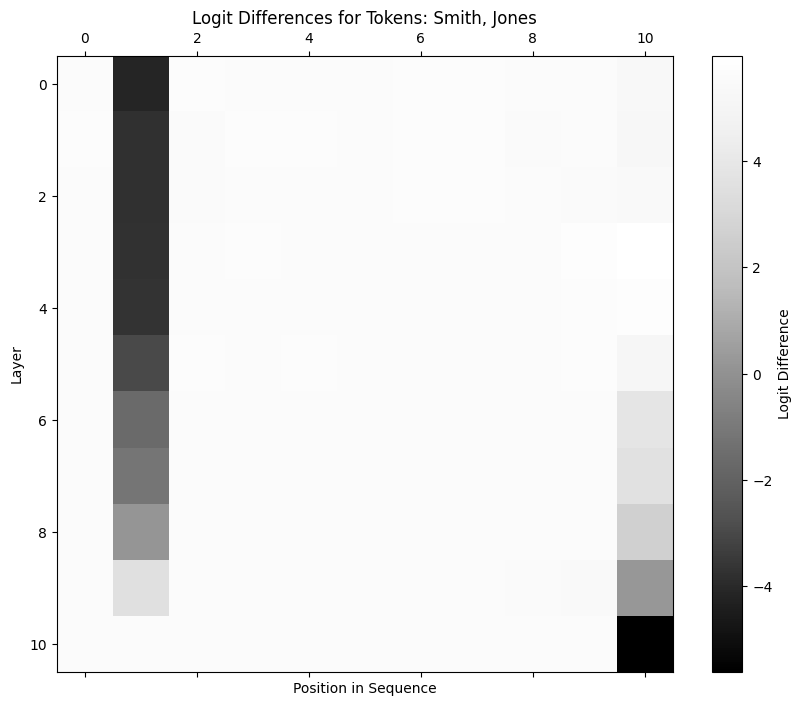

In [ ]:
clean_text = "Michelle Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Michelle"
target_tokens = ["Smith", "Jones"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  Obama (0.1954)
2:  Vis (0.0353)
3:  was (0.0270)
4:  Williams (0.0263)
5:  P (0.0262)
6:  B (0.0235)
7:  Rodriguez (0.0154)
8:  and (0.0147)
9:  K (0.0139)
10:  Lee (0.0122)
11:  R (0.0121)
12:  Fox (0.0118)
13:  Malk (0.0116)
14:  had (0.0113)
15: , (0.0108)
16:  Alexander (0.0106)
17:  Jones (0.0101)
18:  Mc (0.0090)
19:  Ye (0.0089)
20:  Fields (0.0080)


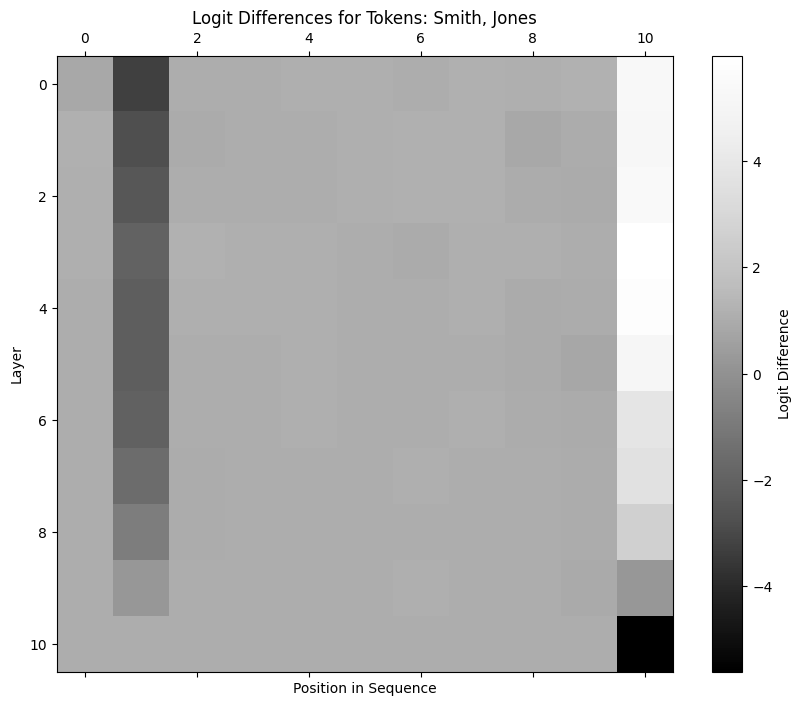

In [ ]:
clean_text = "Jessica Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Jessica"
target_tokens = ["Smith", "Jones"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  is (0.3008)
2:  has (0.1013)
3: , (0.0819)
4:  and (0.0497)
5:  was (0.0469)
6: 's (0.0347)
7:  will (0.0210)
8:  can (0.0160)
9:  could (0.0114)
10:  would (0.0102)
11:  isn (0.0101)
12:  had (0.0100)
13:  doesn (0.0085)
14:  scored (0.0070)
15:  may (0.0068)
16:  played (0.0058)
17:  won (0.0058)
18:  should (0.0055)
19:  might (0.0049)
20:  looks (0.0046)


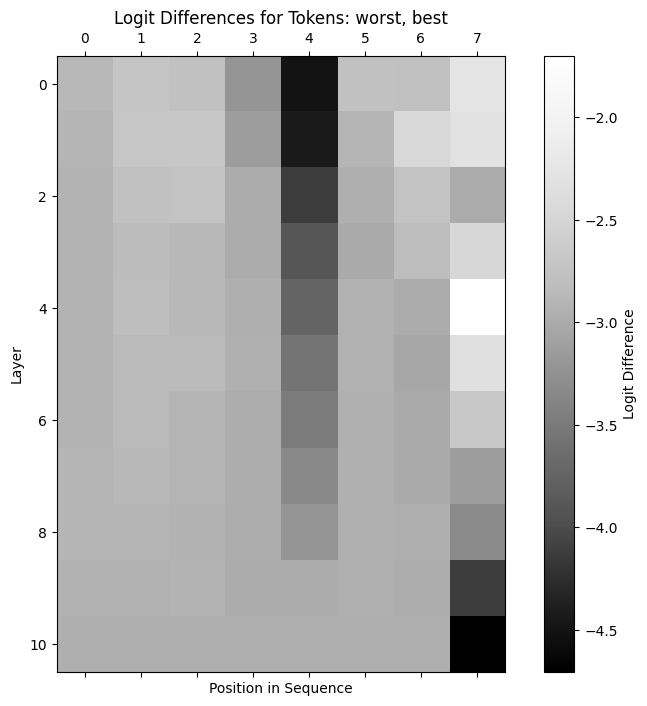

In [ ]:
clean_text = "Messi is the best player. Messi"
corrupted_text = "Messi is the worst player. Messi"
target_tokens = ["worst", "best"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  who (0.1723)
2: , (0.1164)
3:  in (0.0673)
4:  of (0.0585)
5: . (0.0558)
6:  and (0.0494)
7:  named (0.0349)
8:  that (0.0243)
9:  with (0.0206)
10:  called (0.0152)
11:  on (0.0131)
12:  from (0.0130)
13:  whose (0.0113)
14: es (0.0079)
15:  among (0.0076)
16:  at (0.0075)
17:  or (0.0069)
18:  ( (0.0060)
19:  there (0.0055)
20:  to (0.0054)


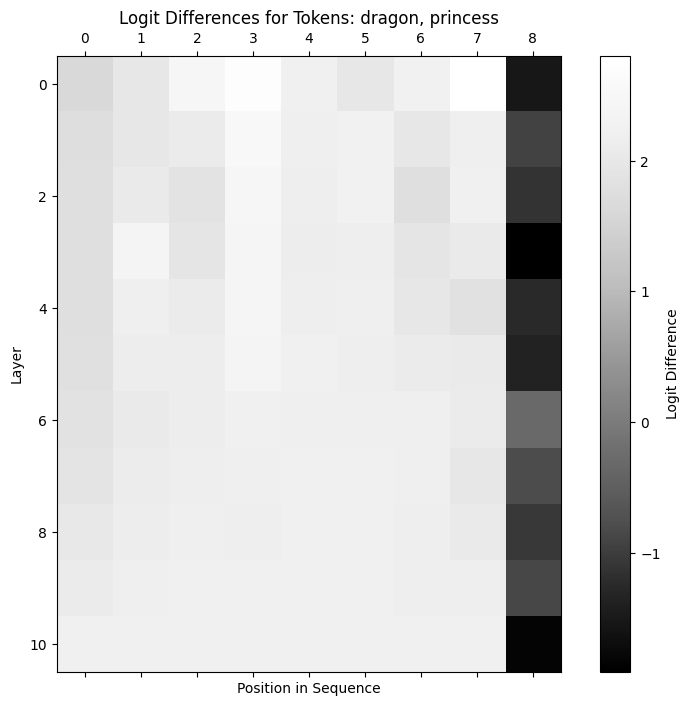

In [ ]:
clean_text = "Once upon a time, there was a princess"
corrupted_text = "Once upon a time, there was a dragon"
target_tokens = ["dragon","princess"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  Green (0.4123)
2:  was (0.1083)
3:  had (0.0323)
4:  is (0.0238)
5:  has (0.0110)
6:  also (0.0107)
7: , (0.0095)
8: ' (0.0094)
9:  and (0.0082)
10: 's (0.0080)
11:  Brown (0.0065)
12:  H (0.0052)
13:  would (0.0046)
14:  did (0.0044)
15:  worked (0.0041)
16:  played (0.0040)
17:  Greene (0.0032)
18:  became (0.0030)
19:  went (0.0028)
20:  knew (0.0028)


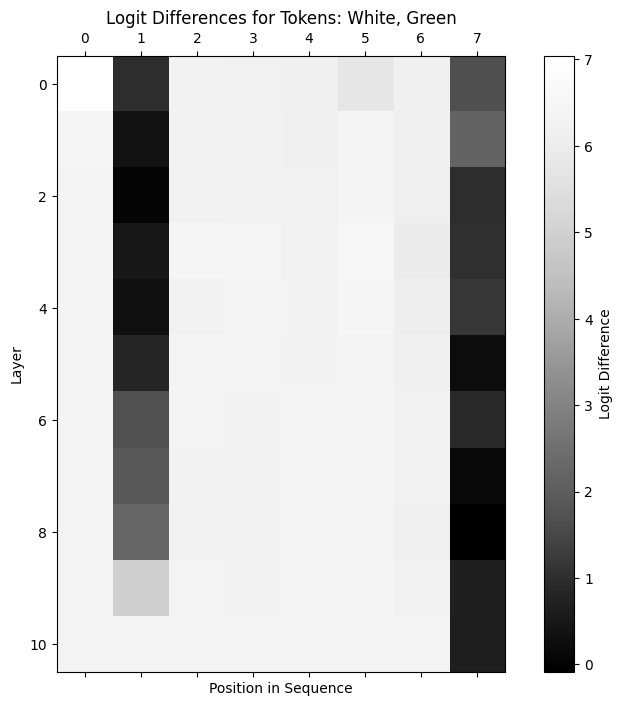

In [ ]:
clean_text = "Thomas Green was an excellent musician. Thomas"
corrupted_text = "Thomas White was an excellent musician. Thomas"
target_tokens = ["White", "Green"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  Green (0.4123)
2:  was (0.1083)
3:  had (0.0323)
4:  is (0.0238)
5:  has (0.0110)
6:  also (0.0107)
7: , (0.0095)
8: ' (0.0094)
9:  and (0.0082)
10: 's (0.0080)
11:  Brown (0.0065)
12:  H (0.0052)
13:  would (0.0046)
14:  did (0.0044)
15:  worked (0.0041)
16:  played (0.0040)
17:  Greene (0.0032)
18:  became (0.0030)
19:  went (0.0028)
20:  knew (0.0028)


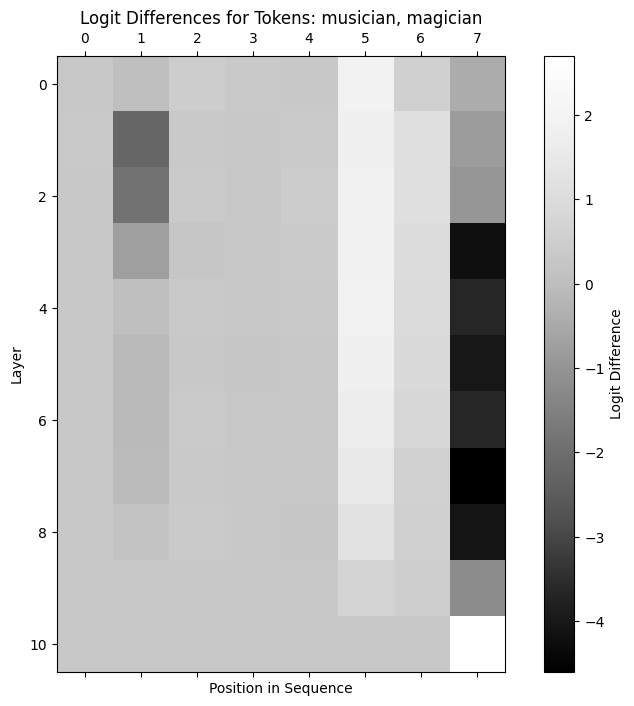

In [ ]:
clean_text = "Thomas Green was an excellent musician. Thomas"
corrupted_text = "Thomas Green was an excellent magician. Thomas"
target_tokens = ["musician", "magician"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  Edison (0.0701)
2:  Jefferson (0.0503)
3:  P (0.0213)
4:  Green (0.0147)
5:  Mann (0.0147)
6:  M (0.0141)
7:  H (0.0115)
8:  was (0.0103)
9:  R (0.0100)
10:  S (0.0089)
11:  Hardy (0.0080)
12:  Hob (0.0079)
13:  B (0.0070)
14:  L (0.0067)
15:  K (0.0064)
16:  Nelson (0.0064)
17:  More (0.0062)
18:  Moore (0.0057)
19:  Brown (0.0054)
20:  D (0.0054)


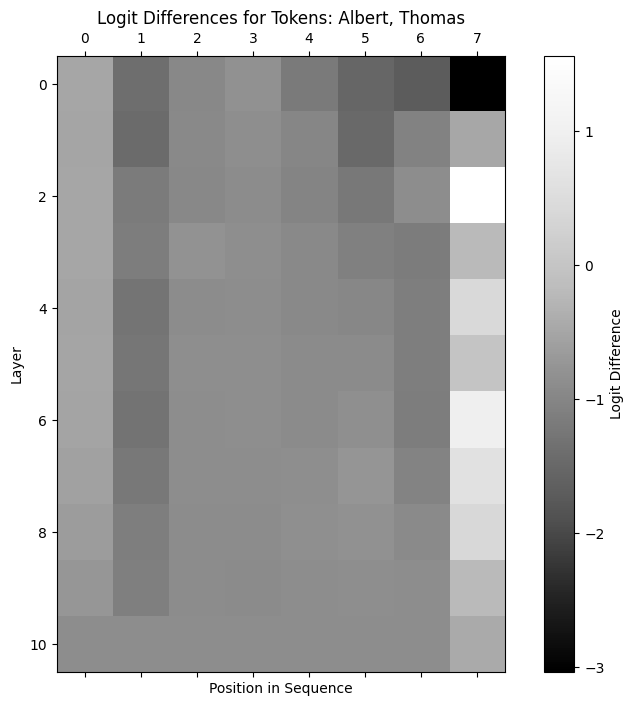

In [ ]:
clean_text = "Albert Green was an excellent musician. Thomas"
corrupted_text = "Thomas Green was an excellent musician. Albert"
target_tokens = ["Albert", "Thomas"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)

Logits shape: torch.Size([1, 50257])
Top 20 continuations:
1:  said (0.1254)
2:  told (0.0933)
3:  was (0.0802)
4:  had (0.0407)
5:  didn (0.0290)
6:  did (0.0257)
7:  gave (0.0231)
8:  refused (0.0196)
9:  asked (0.0181)
10:  is (0.0153)
11: 's (0.0138)
12:  called (0.0129)
13:  took (0.0127)
14:  came (0.0106)
15: , (0.0090)
16:  says (0.0087)
17:  clerk (0.0082)
18:  would (0.0078)
19:  has (0.0078)
20:  sent (0.0072)


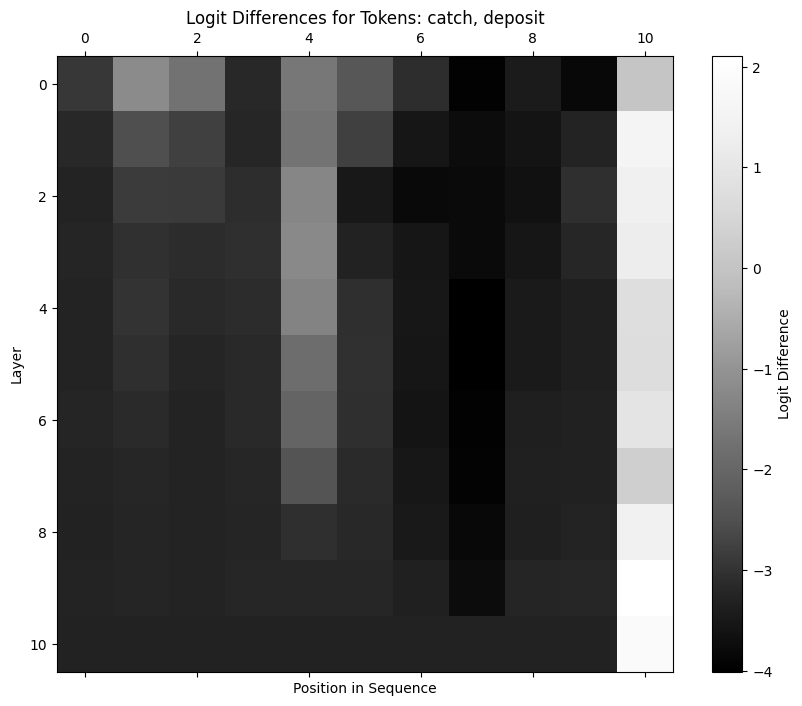

In [ ]:
clean_text = "I went to the bank to deposit money. The bank"
corrupted_text = "I went to the bank to catch fish.The bank"
target_tokens = ["catch", "deposit"]

# Analyze embeddings
analyze_embeddings(model, bpe, clean_text, corrupted_text, target_tokens)